In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_gpu = torch.cuda.is_available()
print(device)

cuda:0


# Initialize for CPU & GPU

In [2]:
if use_gpu:
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric
#     !pip install torch_geometric_temporal  
else:
#     !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git
#     !pip install torch_geometric_temporal


Looking in links: file:///kaggle/input/torch-geometric
Processing /kaggle/input/torch-geometric/torch_scatter-2.1.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_sparse-0.6.17-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_cluster-1.6.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_spline_conv-1.2.2-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_geometric-2.3.1-py3-none-any.whl


# Import

In [3]:
from torch.profiler import profile, record_function, ProfilerActivity
import torch.autograd.profiler as profiler

In [4]:
import numpy as np
import pandas as pd
import os
import re
import json
from scipy.special import perm
from itertools import combinations,chain
from typing import List, Union
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import pickle
import time
from torch import nn
from torch.nn import Linear as Lin
from torch.nn import ReLU
from torch.nn import Sequential as Seq
import torch.nn.functional as F
# from torch_geometric.nn import NNGIN
from torch import autograd

from sklearn.model_selection import train_test_split

In [5]:
from typing import Callable, Tuple, Union

import torch
from torch import Tensor
from torch.nn import Parameter

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import reset, zeros
from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
)


class NNGIN(MessagePassing):
    
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, nn: Callable, aggr: str = 'add',
                 root_weight: bool = True, bias: bool = True, eps: float = 0., train_eps: bool = True, **kwargs):
        super().__init__(aggr=aggr, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.nn = nn
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.in_channels_l = in_channels[0]

        if root_weight:
            self.lin = Linear(in_channels[1], out_channels, bias=False,
                              weight_initializer='uniform')

        if bias:
            self.bias = Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)
        
        self.initial_eps = eps
        if train_eps:
            self.eps = torch.nn.Parameter(torch.empty(1))
        else:
            self.register_buffer('eps', torch.empty(1))

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        reset(self.nn)
        if self.root_weight:
            self.lin.reset_parameters()
        self.eps.data.fill_(self.initial_eps)
        zeros(self.bias)


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj, edge_attr: OptTensor = None, size: Size = None) -> Tensor:

        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        # propagate_type: (x: OptPairTensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)
#         print("x:", x)
        x_r = x[1]
        if x_r is not None and self.root_weight:
            out = out + (1 + self.eps) * self.lin(x_r)

        if self.bias is not None:
            out = out + self.bias

        return out


    def message(self, x_j: Tensor, edge_attr: Tensor) -> Tensor:
#         print("x_j:", x_j)
#         print("edge_attr:", edge_attr)
        weight = self.nn(edge_attr)
        weight = weight.view(-1, self.in_channels_l, self.out_channels)
        return torch.matmul(x_j.unsqueeze(1), weight).squeeze(1)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, aggr={self.aggr}, nn={self.nn})')

In [6]:
# edge_net = Lin(5,25)
# test = NNConv(5,5,nn=edge_net)

# nn.init.ones_(test.lin.weight)
# nn.init.ones_(edge_net.weight)
# nn.init.zeros_(edge_net.bias)

# print(test.lin.weight)
# print(edge_net.weight)
# print(edge_net.bias)

# x = torch.FloatTensor([
#     [0,0,0,0,0],
#     [1,2,3,4,5],
#     [1,2,3,4,5],
# ])

# edge_index = torch.LongTensor([
#     [0,1],
#     [1,2]
# ])

# edge_attr = torch.FloatTensor([
#     [1,1,1,1,1],
#     [2,2,2,2,2],
# #     [3,3,3,3,3],
# ])

# test(x,edge_index,edge_attr)

# DataLoader

In [7]:
Edge_Flag = List[Union[np.ndarray, None]]
Edge_Index = List[Union[np.ndarray, None]]
Edge_Attr = List[Union[np.ndarray, None]]

Node_Flag = List[Union[np.ndarray, None]]
Node_Index = List[Union[np.ndarray, None]]
Node_Attr = List[Union[np.ndarray, None]]
Additional_Attr = List[np.ndarray]



class GraphSignal(object):
    # dynamic node static node attr dynamic edge and edge attr
    def __init__(
        self,
        edge_flag: Edge_Flag,
        edge_index: Edge_Index,
        edge_attr: Edge_Attr,
        node_flag: Node_Flag,
        node_index: Node_Index,
        node_attr: Node_Attr,
        ts_list: List,
    ):
        
        self.edge_flag = torch.LongTensor(edge_flag)
        self.edge_index = torch.LongTensor(edge_index).T.to(device)
        self.edge_attr = edge_attr
        self.node_flag = torch.LongTensor(node_flag)
        self.node_index = torch.LongTensor(node_index).to(device)
        self.node_attr = node_attr
        self.ts_list = ts_list
        self.edge_attr_encoded = None
        self.node_attr_encoded = None
        
        self._set_snapshot_count()

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.edge_flag)
    
    def encode_edge_attr(self, enocder):
        self.edge_attr_encoded = torch.FloatTensor(enocder.transform(self.edge_attr)).to(device)
    
    def encode_node_attr(self, enocder):
        self.node_attr_encoded = torch.FloatTensor(enocder.transform(self.node_attr)).to(device)
        
    def _get_edge_index(self, time_index: int):
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_index = self.edge_index[:,_start:_end]
        return _edge_index

    # def _get_edge_weight(self, time_index: int):
    #     if self.edge_weights[time_index] is None:
    #         return self.edge_weights[time_index]
    #     else:
    #         return torch.FloatTensor(self.edge_weights[time_index])

    def _get_edge_attr(self, time_index: int):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_attr = self.edge_attr_encoded[_start:_end]
        return _edge_attr
    
    def _get_node_index_attr(self, time_index: int):
        if self.node_attr_encoded is None:
            print("Node Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.node_flag[time_index-1]
        _end = self.node_flag[time_index]
        _node_index = self.node_index[_start:_end]
        _node_attr = self.node_attr_encoded[_node_index]
        return _node_index,_node_attr
    
    def _get_timestamp(self, time_index: int):
        _timestamp = self.ts_list[time_index]
        return _timestamp


    def __getitem__(self, time_index: int):
        edge_index = self._get_edge_index(time_index)
        edge_attr = self._get_edge_attr(time_index)
        node_index,node_attr = self._get_node_index_attr(time_index)
        _timestamp = self._get_timestamp(time_index)

        snapshot = Data(
            edge_index=edge_index,
            edge_attr=edge_attr,
            node_index=node_index,
            node_attr=node_attr,
            timestamp = _timestamp
        )
        return snapshot

    def __next__(self):
        if self.t < self.snapshot_count:
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self
    
    def __len__(self):
        return self.snapshot_count


class GraphDatasetLoader(object):
    def __init__(self,input_path=""):
        self.input_path = input_path
        self._read_data()
    
    def _read_data(self):
        self._dataset = np.load(self.input_path)

    def get_dataset(self): # -> DynamicGraphTemporalSignal:
        dataset = GraphSignal(
            edge_flag = self._dataset['edge_flag'],
            edge_index = self._dataset['edge_index'],
            edge_attr = self._dataset['edge_attr'],
            node_flag = self._dataset['node_flag'],
            node_index = self._dataset['node_index'],
            node_attr = self._dataset['node_attr'],
            ts_list = self._dataset['timestamp']
        )
        return dataset

# Model

## MultiNNConv

In [8]:
class MultiNNGIN(torch.nn.Module):
    def __init__(
        self, 
        channels, 
        edge_channels, 
        conv_num, 
        edge_layers, 
        lin_layers
    ):
        super().__init__()
        
        def _create_edge_net(edge_out_channels):
            edge_net = Seq()
            pre_size = edge_channels
            for size in edge_layers:
                edge_net.append(Lin(pre_size,size))
                edge_net.append(ReLU())
                pre_size = size
            edge_net.append(Lin(pre_size,edge_out_channels))
            return edge_net
        
        self.convs = nn.ModuleList()
        for _ in range(conv_num):
            edge_net = _create_edge_net(channels*channels)
            self.convs.append(NNGIN(channels, channels, edge_net, aggr='add'))
        
        self.lins = nn.ModuleList()
        for _ in range(conv_num):
            pre_size = channels
            lin_net = Seq()
            for size in lin_layers[:-1]:
                lin_net.append(Lin(pre_size,size))
                lin_net.append(ReLU())
                pre_size = size
            lin_net.append(Lin(pre_size,channels))
            self.lins.append(lin_net)

    def forward(self, x, edge_index, edge_attr):
        out = x
        for conv, lin in zip(self.convs, self.lins):
            out = conv(
                x=out,
                edge_index=edge_index,
                edge_attr=edge_attr,
            )
            out = lin(out)
        return out

# Graph GRU Unit

In [9]:
class GraphGRU(torch.nn.Module):
    def __init__(
        self,
        channels: int,
        edge_channels: int,
        conv_num: List,
        edge_layers: List,
        lin_layers: List,
        bias: bool = True,
    ):
        super().__init__()

        self.channels = channels
        self.edge_channels = edge_channels
        self.conv_num = conv_num
        self.edge_layers = edge_layers
        self.lin_layers = lin_layers
        self.bias = bias
        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_x_z = MultiNNGIN(
            channels = self.channels,
            edge_channels = self.edge_channels,
            conv_num = self.conv_num,
            edge_layers = self.edge_layers,
            lin_layers = self.lin_layers,
        )

        self.conv_h_z = MultiNNGIN(
            channels = self.channels,
            edge_channels = self.edge_channels,
            conv_num = self.conv_num,
            edge_layers = self.edge_layers,
            lin_layers = self.lin_layers,
        )
        
    def _create_reset_gate_parameters_and_layers(self):

        self.conv_x_r = MultiNNGIN(
            channels = self.channels,
            edge_channels = self.edge_channels,
            conv_num = self.conv_num,
            edge_layers = self.edge_layers,
            lin_layers = self.lin_layers,
        )

        self.conv_h_r = MultiNNGIN(
            channels = self.channels,
            edge_channels = self.edge_channels,
            conv_num = self.conv_num,
            edge_layers = self.edge_layers,
            lin_layers = self.lin_layers,
        )

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_x_h = MultiNNGIN(
            channels = self.channels,
            edge_channels = self.edge_channels,
            conv_num = self.conv_num,
            edge_layers = self.edge_layers,
            lin_layers = self.lin_layers,
        )

        self.conv_h_h = MultiNNGIN(
            channels = self.channels,
            edge_channels = self.edge_channels,
            conv_num = self.conv_num,
            edge_layers = self.edge_layers,
            lin_layers = self.lin_layers,
        )

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, edge_attr, H):
        Z = self.conv_x_z(X, edge_index, edge_attr)
        Z = Z + self.conv_h_z(H, edge_index, edge_attr)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_attr, H):
        R = self.conv_x_r(X, edge_index, edge_attr)
        R = R + self.conv_h_r(H, edge_index, edge_attr)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, edge_attr, H, R):
        H_tilde = self.conv_x_h(X, edge_index, edge_attr)
        H_tilde = H_tilde + self.conv_h_h(H * R, edge_index, edge_attr)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
            self,
            X: torch.FloatTensor,
            edge_index: torch.LongTensor,
            edge_attr: torch.FloatTensor,
            H: torch.FloatTensor = None,
        ) -> torch.FloatTensor:
            H = self._set_hidden_state(X, H)
            Z = self._calculate_update_gate(X, edge_index, edge_attr, H)
            R = self._calculate_reset_gate(X, edge_index, edge_attr, H)
            H_tilde = self._calculate_candidate_state(X, edge_index, edge_attr, H, R)
            H = self._calculate_hidden_state(Z, H, H_tilde)
            return H

# Graph GRU Layer and Global Hidden Function

In [10]:
def create_hidden(num_node, out_channels):
#     hidden_global = torch.FloatTensor(np.zeros([num_node,out_channels])).to(device)
    hidden =torch.zeros([num_node,out_channels], dtype=torch.float).to(device)
    return hidden

def select_hidden(hidden, index):
#     h = hidden_global[index] #REGULAR INDEXING
    h = hidden.index_select(dim=0, index=index) #INDEX SELECT
    return h

def update_hidden(num_node, out_channels, h, index):
    # hidden_global[index] = h.detach() #REGULAR INDEXING
    # for key,value in mapping.items():
    #     hidden_global[value] = h[key] 
    hidden =torch.zeros([num_node,out_channels], dtype=torch.float).to(device)
    hidden.index_add_(0, index, h)  
    return hidden

class GraphGRULayer(torch.nn.Module):
    def __init__(
        self,
        channels: int,
        edge_channels: int,
        conv_num: int,
        edge_layers: List,
        lin_layers: List,
        bias: bool = True,
    ):
        super().__init__()
        self.gru = GraphGRU(
            channels = channels,
            edge_channels = edge_channels,
            conv_num = conv_num,
            edge_layers = edge_layers,
            lin_layers = lin_layers,
            bias = bias
        )
        
        self.channels = channels
        
    def forward(
        self,
        X: torch.FloatTensor,
        node_index: torch.LongTensor,
        node_flag: torch.LongTensor,
        edge_index: torch.LongTensor,
        edge_attr: torch.FloatTensor,
        edge_flag: torch.LongTensor,
        num_node: int,
        direction: bool # True for Forward; False for Backward
    ) -> torch.FloatTensor:
        
        X_split = torch.tensor_split(X, node_flag)
        node_index_split = torch.tensor_split(node_index, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        edge_attr_split = torch.tensor_split(edge_attr, edge_flag)
        
        hidden = create_hidden(num_node, self.channels)
        
        outs = []
        if direction:
            snapshot_index = range(len(X_split))
        else:
            snapshot_index = range(len(X_split)-1,-1,-1)
        for i_snapshot in snapshot_index:
            _X = X_split[i_snapshot]
            _node_index = node_index_split[i_snapshot]
            _edge_index = edge_index_split[i_snapshot]
            _edge_attr = edge_attr_split[i_snapshot]

            _hidden = select_hidden(hidden, _node_index)
            _new_hidden = self.gru(_X, _edge_index, _edge_attr, _hidden)
            hidden = update_hidden(num_node, self.channels, _new_hidden, _node_index)
            outs.append(_new_hidden)
        if direction:
            H = torch.cat(outs)
        else:
            H = torch.cat(outs[::-1])
        return H

## TGAE

In [11]:
class TGAE(torch.nn.Module): # Not Heterogeneous
    def __init__(
        self, 
        in_channels, 
        out_channels, 
        edge_channels, 
        embed_layers,  
        decide_layers,
        gru_conv_num, 
        gru_edge_layers, 
        gru_lin_layers
    ):
        super(TGAE, self).__init__()
        
        # Encoder
        layers = []
        pre_h_num = in_channels
        for h_num in embed_layers[:-1]:
#             layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,embed_layers[-1]))
        self.encoder_embedding_net = Seq(*layers)
        
        self.encoder_gru = GraphGRULayer(
            channels=embed_layers[-1],
            edge_channels=edge_channels,
            conv_num=gru_conv_num,
            edge_layers=gru_edge_layers,
            lin_layers=gru_lin_layers,
        )

        layers = []
        pre_h_num = embed_layers[-1]
        for h_num in decide_layers:
#             layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,out_channels))
        self.encoder_deciding_net = Seq(*layers)
        
        # Decoder
        layers = []
        pre_h_num = out_channels
        for h_num in decide_layers[::-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,embed_layers[-1]))
        self.decoder_deciding_net = Seq(*layers)
        
        self.decoder_gru = GraphGRULayer(
            channels=embed_layers[-1],
            edge_channels=edge_channels,
            conv_num=gru_conv_num,
            edge_layers=gru_edge_layers,
            lin_layers=gru_lin_layers,
        )
        
        layers = []
        pre_h_num = embed_layers[-1]
        for h_num in embed_layers[:-1][::-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,in_channels))
        self.decoder_embedding_net = Seq(*layers)
        

    def forward(self, x, node_index, node_flag, edge_index, edge_attr, edge_flag, num_node):
        # Encoder
        out = self.encoder_embedding_net(x)
        
        # GNN layer
#         with profiler.record_function("gru encoder"):
        h_encoder = self.encoder_gru(out, node_index, node_flag, edge_index, edge_attr, edge_flag, num_node, True) 
        
        out = self.encoder_deciding_net(h_encoder)

        out = self.decoder_deciding_net(out)
        
        # TODO Reverse Edge Index 
#         with profiler.record_function("gru decoder"):
        h_decoder = self.decoder_gru(out, node_index, node_flag, torch.flip(edge_index,dims=(0,)), edge_attr, edge_flag, num_node, True)
        
        out = self.decoder_embedding_net(h_decoder)

        return out
    

# Training

## Read Data

In [12]:
data_dir_0 = '/kaggle/input/dissertation-data'
data_dir_1 = '2021-09-11-umbrella-experiment-32run-fran'


signals = []
y = []
with open(os.path.join(data_dir_0, data_dir_1, "annotated.json")) as f:
    annotated_dict = json.load(f)

for data_dir_2 in os.listdir(os.path.join(data_dir_0, data_dir_1)):
    if data_dir_2 == "annotated.json":
        continue
    r = re.compile(".*.npz")
    graph_files = list(filter(r.match, os.listdir(os.path.join(data_dir_0, data_dir_1, data_dir_2))))

    if len(graph_files) > 1:
        print("Multiple Graph Files!")
        raise
    if len(graph_files) == 0:
        print("Not Found Graph File!")
        raise

    dataloader = GraphDatasetLoader(os.path.join(data_dir_0, data_dir_1, data_dir_2, graph_files[0]))
    signal = dataloader.get_dataset()
    signals.append(signal)
    y.append(annotated_dict[data_dir_2])

# split train and test dataset
signals_train, signals_test, y_train, y_test = train_test_split(signals, y, test_size=0.2, random_state=1)
signals_train, signals_val, y_train, y_val = train_test_split(signals_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [13]:
node_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
node_attr_encoder = node_attr_encoder.fit(np.concatenate([sample.node_attr for sample in signals_train]))

edge_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
edge_attr_encoder = edge_attr_encoder.fit(np.concatenate([sample.edge_attr for sample in signals_train]))

for signal in signals_train:
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)

X_train = []
for signal in signals_train:
#     X_train.append(list(signal))
    X_train.append(signal.node_attr_encoded.index_select(dim=0,index=signal.node_index))
    
num_node_train = []
for signal in signals_train:
    num_node_train.append(signal.node_attr.shape[0])

    
for signal in signals_val:
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)

X_val = []
# for signal in signals_val:
#     X_val.append(list(signal))
for signal in signals_val:
#     X_train.append(list(signal))
    X_val.append(signal.node_attr_encoded.index_select(dim=0,index=signal.node_index))

nums_node_val = []
for signal in signals_val:
    nums_node_val.append(signal.node_attr.shape[0])

IN_CHANNELS = signals_train[0].node_attr_encoded.shape[1]
EDGE_CHANNELS = signals_train[0].edge_attr_encoded.shape[1]

In [14]:
# for sample in X_train[:1]:
#     for snapshot in sample:
#         node_attr = snapshot.node_attr
#         node_index = snapshot.node_index
#         edge_attr = snapshot.edge_attr
#         edge_index = snapshot.edge_index
        
#         print(f"node_attr: {node_attr.shape}")
#         print(f"node_index: {node_index.shape}")
#         print(f"edge_attr: {edge_attr.shape}")
#         print(f"edge_index: {edge_index.shape}")

In [15]:
model = TGAE(
    in_channels=IN_CHANNELS, 
    out_channels=5, 
    edge_channels=EDGE_CHANNELS, 
    embed_layers=[16,32],
    decide_layers=[16,16],
    gru_conv_num=2, 
    gru_edge_layers=[EDGE_CHANNELS*2], 
    gru_lin_layers=[32,64]
)

loss_f = torch.nn.MSELoss(reduction = 'none')
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4, weight_decay=1e-5)

model = model.to(device)
loss_f = loss_f.to(device)
print(model)

TGAE(
  (encoder_embedding_net): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (encoder_gru): GraphGRULayer(
    (gru): GraphGRU(
      (conv_x_z): MultiNNGIN(
        (convs): ModuleList(
          (0-1): 2 x NNGIN(32, 32, aggr=add, nn=Sequential(
            (0): Linear(in_features=58, out_features=116, bias=True)
            (1): ReLU()
            (2): Linear(in_features=116, out_features=1024, bias=True)
          ))
        )
        (lins): ModuleList(
          (0-1): 2 x Sequential(
            (0): Linear(in_features=32, out_features=32, bias=True)
            (1): ReLU()
            (2): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (conv_h_z): MultiNNGIN(
        (convs): ModuleList(
          (0-1): 2 x NNGIN(32, 32, aggr=add, nn=Sequential(
            (0): Linear(in_features=58, out_features=116, bias=

## Train Loop

In [16]:
# train_loop
def train_loop(signal, model, loss_fn, optimizer, device):
    model.train()
    
    X = signal.node_attr_encoded.index_select(dim=0,index=signal.node_index)
    node_index = signal.node_index
    node_flag = signal.node_flag[:-1]
    edge_index = signal.edge_index
    edge_attr = signal.edge_attr_encoded
    edge_flag = signal.edge_flag[:-1]
    
    outs = model(X, node_index, node_flag, edge_index, edge_attr, edge_flag, signal.node_attr.shape[0])

    train_losses = torch.sqrt(torch.sum(loss_f(X, outs),dim=1))
    total_loss = torch.mean(train_losses)
    snapshot_losses = [torch.mean(loss).cpu().numpy() for loss in torch.tensor_split(train_losses.detach(), node_flag)]
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    return snapshot_losses

## Test Loop

In [29]:
# test_loop
def test_loop(signal, model, loss_fn, optimizer, device):
    with torch.no_grad():
        X = signal.node_attr_encoded.index_select(dim=0,index=signal.node_index)
        node_index = signal.node_index
        node_flag = signal.node_flag[:-1]
        edge_index = signal.edge_index
        edge_attr = signal.edge_attr_encoded
        edge_flag = signal.edge_flag[:-1]

        outs = model(X, node_index, node_flag, edge_index, edge_attr, edge_flag, signal.node_attr.shape[0])

        train_losses = torch.sqrt(torch.sum(loss_f(X, outs),dim=1))
        total_loss = torch.mean(train_losses)
        snapshot_losses = [torch.mean(loss).cpu().numpy() for loss in torch.tensor_split(train_losses.detach(), node_flag)]
    
    return snapshot_losses

In [18]:
GLOBAL_EPOCH = 0
def train_function(num_epoch):
    global GLOBAL_EPOCH
    
    history_train = []
    history_val = []

    for i_epoch in range(1,num_epoch+1):
        train_losses = []
        _start = time.time()
        for signal in signals_train:
            snapshot_losses = train_loop(signal, model, loss_f, optimizer, device)
#             print(np.mean(train_loss))
            train_losses.append(np.mean(snapshot_losses))
            
        
        if i_epoch % 5 == 0:
            val_losses = []
            for signal in signals_val:
                snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
#                 print(np.mean(val_loss))
                val_losses.append(np.mean(snapshot_losses))
            _end = time.time()
            
            history_train.append(np.mean(train_losses))
            history_val.append(np.mean(val_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train RMSE {np.mean(train_losses):.4f} val RMSE{np.mean(val_losses):.4f}")
        else:
            _end = time.time()
            history_train.append(np.mean(train_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train RMSE {np.mean(train_losses):.4f}")
    GLOBAL_EPOCH += num_epoch
    return (history_train,history_val)

In [19]:
history_train_list = []
history_val_list = []

1/50: cost 41.5439s train RMSE 1.0127
2/50: cost 39.1253s train RMSE 0.9084
3/50: cost 39.0770s train RMSE 0.7207
4/50: cost 39.2564s train RMSE 0.5462
5/50: cost 45.2190s train RMSE 0.4870 val RMSE1.3825
6/50: cost 39.3166s train RMSE 0.4402
7/50: cost 39.2395s train RMSE 0.4187
8/50: cost 39.6738s train RMSE 0.4038
9/50: cost 39.4864s train RMSE 0.3866
10/50: cost 44.6951s train RMSE 0.3682 val RMSE1.3180
11/50: cost 40.0618s train RMSE 0.3444
12/50: cost 39.4658s train RMSE 0.3219
13/50: cost 39.2783s train RMSE 0.3009
14/50: cost 39.4647s train RMSE 0.2835
15/50: cost 45.0356s train RMSE 0.2695 val RMSE1.2223
16/50: cost 39.2085s train RMSE 0.2503
17/50: cost 39.4874s train RMSE 0.2302
18/50: cost 39.6103s train RMSE 0.2222
19/50: cost 39.9360s train RMSE 0.2152
20/50: cost 44.6616s train RMSE 0.2074 val RMSE1.2203
21/50: cost 39.6397s train RMSE 0.2042
22/50: cost 39.9179s train RMSE 0.1994
23/50: cost 39.4398s train RMSE 0.1944
24/50: cost 39.5867s train RMSE 0.1887
25/50: cost 4

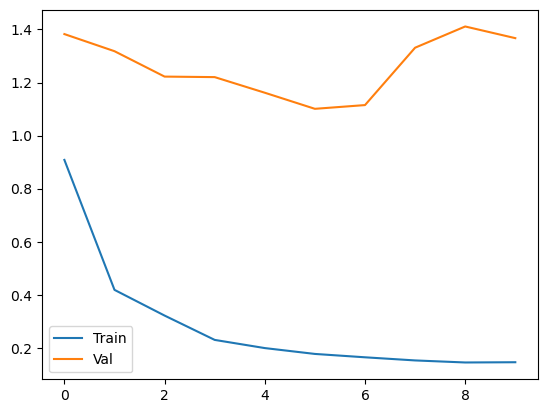

In [20]:
history_train, history_val = train_function(50)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::5],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()

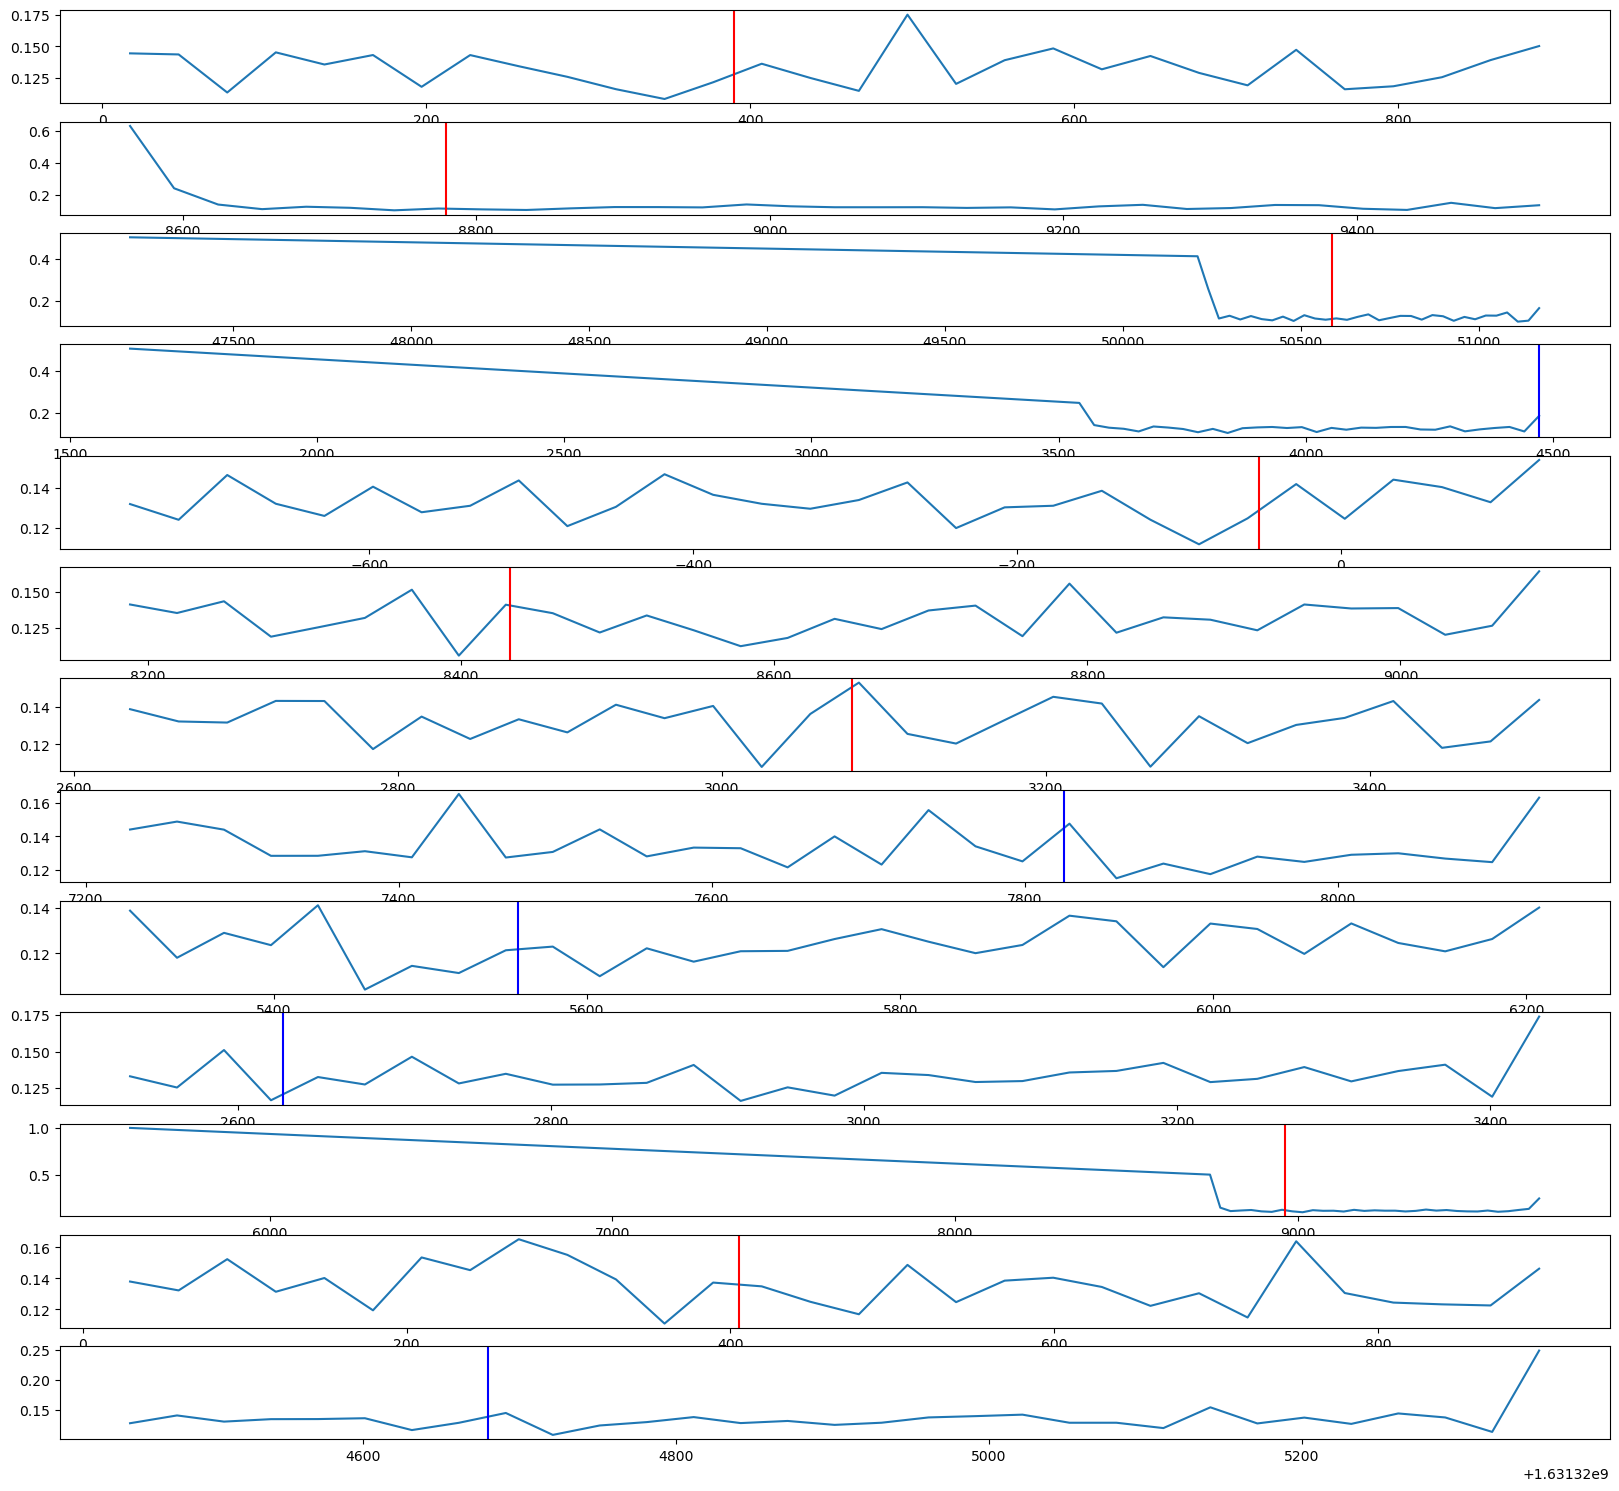

In [30]:
fig = plt.figure(figsize=(20,20))    
for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
#                 print(np.mean(val_loss))
#     val_losses.append(np.mean(snapshot_losses))
    ts_list = signal.ts_list
    plt.subplot(len(signals_val)+1,1,i_signal+1)
#     print(len(snapshot_losses))
    plt.plot(ts_list,snapshot_losses)
    if y[0] == 'dos':
        plt.axvline(x = float(y[1]), color = 'red', label = y[0])
    if y[0] == 'privesc':
        plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# plt.show()
plt.savefig(f'val_res_TGAE_NNConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

In [22]:
torch.save(model,f"TGAE_NNConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

In [23]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], use_cuda=True, record_shapes=True) as prof:
#         history_train, history_val = train_function(1)
#         history_train_list += history_train
#         history_val_list += history_val
#         plt.plot(history_train_list[1::5],label="Train")
#         plt.plot(history_val_list,label="Val")
#         plt.legend()
# print(prof.key_averages().table(sort_by="cuda_time_total"))

In [24]:
# print(prof.key_averages().table(sort_by="cpu_time_total"))

In [25]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,snapshot_losses[:-1])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig('val_res.png')

In [26]:
# torch.save(model,f"{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

In [27]:
# history_train, history_val = train_function(100)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [28]:
# states_encoder_val = []
# states_decoder_val = []
# for num_node in nums_node_val:
#     states_encoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.gnn_out_channels))
#     states_decoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.embedding_hidden_nums[-1]))    

# fig = plt.figure(figsize=(20,20))    
# for i_sample, (sample, y, hidden_encoder_global, hidden_decoder_global) in enumerate(zip(X_val, y_val, states_encoder_val, states_decoder_val)):
#     val_loss = test_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_f, optimizer, device)
#     # print(np.mean(val_loss))
#     ts_list = [snapshot.timestamp for snapshot in sample]
#     plt.subplot(len(X_val)+1,1,i_sample+1)
#     plt.plot(ts_list,val_loss)
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# plt.show()